# Predicting Wine Quality

Regression is the task of fitting a model to data. If things go well, the model might provide useful predictions in response to new data. This notebook shows how linear programming and least absolute deviation (LAD) regression can be used to create a linear model for predicting wine quality based on physical and chemical properties. The example uses a well known data set from the machine learning community.

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Downloading the data set

Physical, chemical, and sensory quality properties were collected for a large number of red and white wines produced in the Portugal then donated to the UCI machine learning repository (Cortez, Paulo, Cerdeira, A., Almeida, F., Matos, T. & Reis, J.. (2009). Wine Quality. UCI Machine Learning Repository.) The following cell reads the data for red wines directly from the UCI machine learning repository.

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

wines = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
display(wines)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Model Objective: Mean Absolute Deviation (MAD)

Given a n repeated observations of a response variable $y_i$ (in this wine quality), the **mean absolute deviation** (MAD) of $y_i$ from the mean value $\bar{y}$ is

$$\text{MAD}\,(y) = \frac{1}{n} \sum_{i=1}^n | y_i - \bar{y}|$$

The goal of the regression is find coefficients $m_j$ and $b$ to minimize

$$
\begin{align*}
\text{MAD}\,(\hat{y}) & = \min \frac{1}{n} \sum_{i=1}^n | y_i - \hat{y}_i| \\
\\
\text{s. t.}\quad \hat{y}_i & = \sum_{j=1}^J x_{i, j} m_j + b & \forall i = 1, \dots, n\
\end{align*}
$$

where $x_{i, j}$ are values of 'explanatory' variables. A successful model would demonstrate a substantial reduction from $\text{MAD}\,(y)$ to $\text{MAD}\,(\hat{y})$. The value of $\text{MAD}\,(y)$ sets a benchmark for the regression.


MAD =  0.6831779242889809


Text(0.5, 0, 'observation')

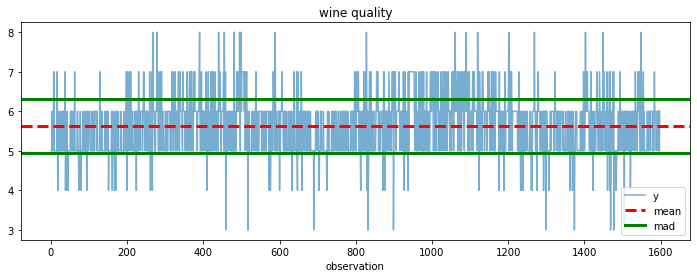

In [3]:
def MAD(df):
    return (df - df.mean()).abs().mean()

print("MAD = ", MAD(wines["quality"]))
      
fig, ax = plt.subplots(figsize=(12, 4))
ax = wines["quality"].plot(alpha=0.6, title="wine quality")
ax.axhline(wines["quality"].mean(), color='r', ls='--', lw=3)
  
mad = MAD(wines["quality"])
ax.axhline(wines["quality"].mean() + mad, color='g', lw=3)
ax.axhline(wines["quality"].mean() - mad, color='g', lw=3)
ax.legend(["y", "mean", "mad"])
ax.set_xlabel("observation")

## A preliminary look at the data

The data consists of 1,599 measurements of eleven physical and chemical characteristics plus an integer measure of sensory quality recorded on a scale from 3 to 8. Histograms provides insight into the values and variability of the data set.

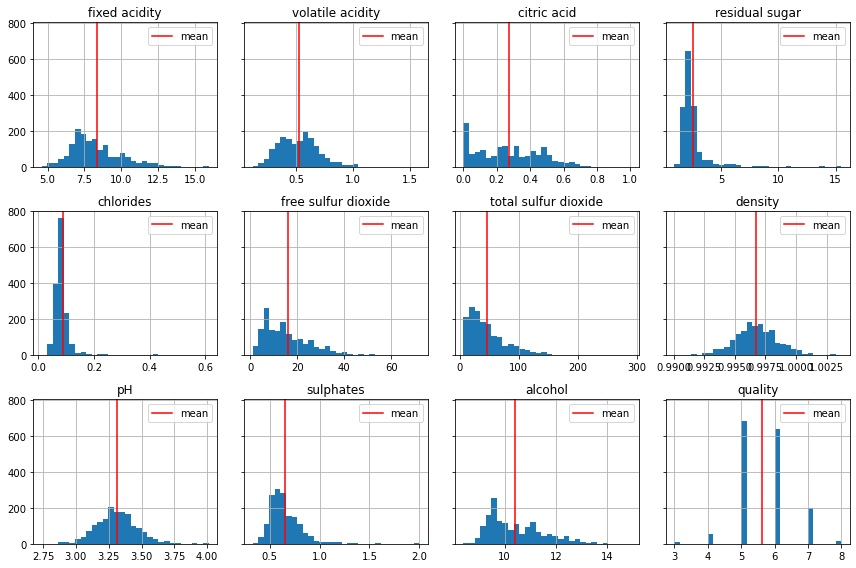

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True)

for ax, column in zip(axes.flatten(), wines.columns):
    wines[column].hist(ax=ax, bins=30)
    ax.axvline(wines[column].mean(), color='r', label="mean")
    ax.set_title(column)
    ax.legend()
    
plt.tight_layout()

## Which features influence reported wine quality?

The art of regression is to identify the features that have explanatory value for a response of interest. This is where a person with deep knowledge of an application area, in this case an experienced onenologist will have a head start compared to the naive data scientist. In the absence of the experience, we proceed by examining the correlation among the variables in the data set.

<AxesSubplot:>

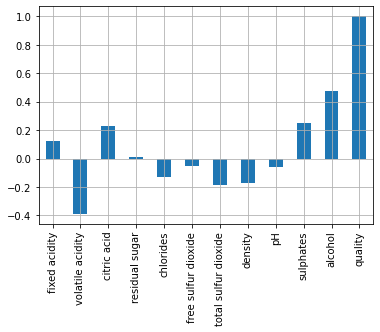

In [5]:
wines.corr()["quality"].plot(kind="bar", grid=True)

In [6]:
wines[["volatile acidity", "density", "alcohol", "quality"]].corr()

,volatile acidity,density,alcohol,quality
volatile acidity,1.000000,0.022026,-0.202288,-0.390558
density,0.022026,1.000000,-0.496180,-0.174919
alcohol,-0.202288,-0.496180,1.000000,0.476166
quality,-0.390558,-0.174919,0.476166,1.000000


Collectively, these figures suggest `alcohol` is a strong correlate of `quality`, and several additional factors as  candidates for explanatory variables..

## LAD line fitting to identify features

An alternative approach is perform a series of single feature LAD regressions to determine which features have the largest impact on reducing the mean absolute deviations in the residuals.

$$
\begin{align*}
\min \frac{1}{I} \sum_{i\in I} \left| y_i - a x_i - b \right|
\end{align*}
$$

This computation has been presented in a prior notebook.

In [7]:
import pyomo.environ as pyo

def lad_fit_1(df, y_col, x_col):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(df))

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I)
    def X(m, i):
        return df.loc[i-1, x_col]

    # regression
    m.a = pyo.Var()
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return m.a * m.X[i] + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m .y[i]

    @m.Objective(sense=pyo.minimize)
    def mean_absolute_deviation(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)/len(m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = lad_fit_1(wines, "quality", "alcohol")

print(m.mean_absolute_deviation())

0.5411666004609164


This calculation is performed for all variables to determine which variables are the best candidates to explain deviations in wine quality.

Text(0.5, 1.0, 'mean absolute deviation following regression')

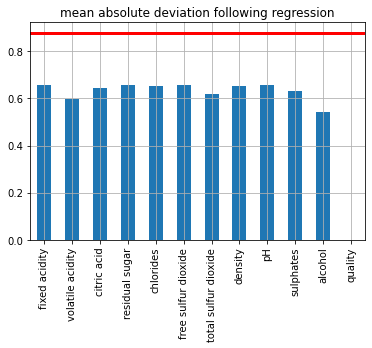

In [8]:
mad = (wines["alcohol"] - wines["alcohol"].mean()).abs().mean()
vars = {i: lad_fit_1(wines, "quality", i).mean_absolute_deviation() for i in wines.columns}

fig, ax = plt.subplots()
pd.Series(vars).plot(kind="bar", ax=ax, grid=True)
ax.axhline(mad, color='r', lw=3)
ax.set_title('mean absolute deviation following regression')

<AxesSubplot:xlabel='quality', ylabel='prediction'>

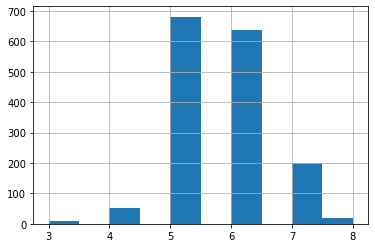

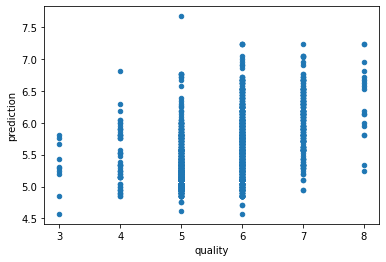

In [9]:
wines["prediction"] = [m.prediction[i]() for i in m.I]
wines["quality"].hist(label="data")

wines.plot(x="quality", y="prediction", kind="scatter")

## Multivariable Regression

0.4997972059178049
alcohol  0.34242497
volatile acidity  -0.98061746
citric acid  -0.28927641
sulphates  0.90609119
total sulfur dioxide  -0.0021873578
density  -18.500829
fixed acidity  0.063818378


<AxesSubplot:xlabel='quality', ylabel='prediction'>

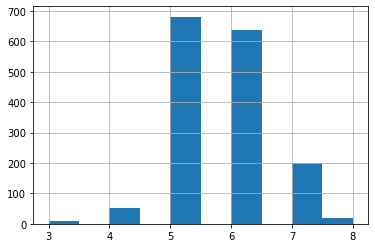

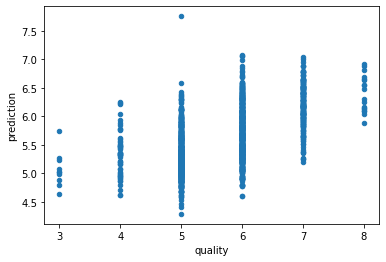

In [10]:
import pyomo.environ as pyo

def l1_fit_2(df, y_col, x_cols):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(df))
    m.J = pyo.Set(initialize=x_cols)

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I, m.J)
    def X(m, i, j):
        return df.loc[i-1, j]

    # regression
    m.a = pyo.Var(m.J)
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return sum(m.a[j] * m.X[i, j] for j in m.J) + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m.y[i]

    @m.Objective(sense=pyo.minimize)
    def mean_absolute_deviation(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)/len(m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = l1_fit_2(wines, "quality", 
                    ["alcohol", "volatile acidity", "citric acid", "sulphates", \
                     "total sulfur dioxide", "density", "fixed acidity"])
print(m.mean_absolute_deviation())

for j in m.J:
    print(f"{j}  {m.a[j]()}")

wines["prediction"] = [m.prediction[i]() for i in m.I]
wines["quality"].hist(label="data")

wines.plot(x="quality", y="prediction", kind="scatter")


## How do these models perform?

The linear regression model clearly has some capability to explain the observed deviations in wine quality. Tabulating the results of the regression using the MAD statistic we find

| Regressors | MAD |
| :--- | ---: |
| none | 0.683 |
| alcohol only | 0.541 | 
| all | 0.500 |

Are these models good enough to replace human judgment of wine quality? The reader can be the judge.